# Lesson 3.3 线性回归手动实现与模型局限

&emsp;&emsp;在创建好了数据生成器之后，接下来即可进行手动线性回归建模实验。

In [ ]:
# 科学计算模块
import numpy as np
import pandas as pd

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# 自定义模块
from ML_basic_function import *

## 一、线性回归的手动实现

&emsp;&emsp;接下来，我们尝试进行线性回归模型的手动建模实验。建模过程将遵照机器学习的一般建模流程，并且借助NumPy所提供的相关工具来进行实现。通过本次实验，我们将进一步深化对机器学习建模流程的理解，并且也将进一步熟悉对编程基础工具的掌握。

### 1.根据机器学习建模流程构建线性回归模型

- Step 1.数据准备

&emsp;&emsp;首先，是准备数据集。我们利用数据生成器创建一个扰动项不太大的数据集：

In [ ]:
# 设置随机数种子
np.random.seed(24)   

# 扰动项取值为0.01
features, labels = arrayGenReg(delta=0.01)

In [ ]:
features

array([[ 1.32921217, -0.77003345,  1.        ],
       [-0.31628036, -0.99081039,  1.        ],
       [-1.07081626, -1.43871328,  1.        ],
       ...,
       [ 1.5507578 , -0.35986144,  1.        ],
       [-1.36267161, -0.61353562,  1.        ],
       [-1.44029131,  0.50439425,  1.        ]])

> 其中，features也被称为特征矩阵、labels也被称为标签数组

- Step 2.模型选取

&emsp;&emsp;接下来，选取模型对上述回归类问题数据进行建模。此处我们选取带有截距项的多元线性回归方程进行建模，基本模型为：

$$ f(x) = w_1x_1+w_2x_2+b $$

令$\hat w = [w_1,w_2,b]^T$，$\hat x = [x_1,x_2, 1]^T$，则上式可写为

<center> $ f(x) = \hat w^T\hat x $ </center>

> 注，此处如果要构建一个不带截距项的模型，则可另X为原始特征矩阵带入进行建模。

- Step 3.构造损失函数

&emsp;&emsp;对于线性回归来说，我们可以参照SSE、MSE或者RMSE的计算过程构造损失函数。由于目前模型参数还只是隐式的值（在代码中并不显示），我们可以简单尝试，通过人工设置一组$\hat w$来计算SSE。

- 另$\hat w$为一组随机值，计算SSE

In [ ]:
np.random.seed(24)
w = np.random.randn(3).reshape(-1, 1)
w

array([[ 1.32921217],
       [-0.77003345],
       [-0.31628036]])

&emsp;&emsp;此时模型输出结果为：

In [ ]:
y_hat = features.dot(w)
y_hat[:10]

array([[ 2.04347616],
       [ 0.02627308],
       [-0.63176501],
       [ 0.20623364],
       [-2.64718921],
       [-0.86880796],
       [ 0.88171608],
       [-1.61055557],
       [ 0.80113619],
       [-0.49279524]])

In [ ]:
labels[:10]

array([[ 4.43811826],
       [ 1.375912  ],
       [ 0.30286597],
       [ 1.81970897],
       [-2.47783626],
       [ 0.47374318],
       [ 2.83085905],
       [-0.83695165],
       [ 2.84344069],
       [ 0.8176895 ]])

&emsp;&emsp;据此，根据公式$SSE= ||y - X\hat w||_2^2 = (y - \hat y)^T(y - \hat y)$，SSE计算结果为：

In [ ]:
(labels - y_hat).T.dot(labels - y_hat)

array([[2093.52940481]])

In [ ]:
# 计算MSE
(labels - y_hat).T.dot(labels - y_hat) / len(labels)

array([[2.0935294]])

能够看出，在当前参数取值下，模型输出结果和真实结果相距甚远。

不过，为了后续快速计算SSE，我们可以将上述SSE计算过程封装为一个函数，令其在输入特征矩阵、标签数组和真实参数情况下即可输出SSE计算结果：

In [ ]:
def SSELoss(X, w, y):
    """
    SSE计算函数
    
    :param X：输入数据的特征矩阵
    :param w：线性方程参数
    :param y：输入数据的标签数组
    :return SSE：返回对应数据集预测结果和真实结果的误差平方和 
    """
    y_hat = X.dot(w)
    SSE = (y - y_hat).T.dot(y - y_hat)
    return SSE

In [ ]:
# 简单测试函数性能
SSELoss(features, w, labels)

array([[2093.52940481]])

> 实验结束后，需要将上述SSELoss函数写入ML_basic_function.py中。

- Step 4.利用最小二乘法求解损失函数

&emsp;&emsp;接下来，我们需要在SSELoss中找到一组最佳的参数取值，另模型预测结果和真实结果尽可能接近。此处我们利用Lesson 2中介绍的最小二乘法来进行求解，最小二乘法求解模型参数公式为：

$$\hat w = (X^TX)^{-1}X^Ty$$

&emsp;&emsp;值得注意的是，最小二乘法在进行求解过程中，需要特征矩阵的交叉乘积可逆，也就是$X^TX$必须存在逆矩阵。我们可以通过计算其行列式来判断该条件是否满足：

In [ ]:
np.linalg.det(features.T.dot(features))

967456500.179829

&emsp;&emsp;行列式不为0，因此$X^TX$逆矩阵存在，可以通过最小二乘法求解。具体求解方法分为两种，其一是使用NumPy中线性代数基本方法，根据上述公式进行求解，同时也可以直接使用lstsq函数进行求解。

- 基础方法求解

In [ ]:
w = np.linalg.inv(features.T.dot(features)).dot(features.T).dot(labels)
w

array([[ 1.99961892],
       [-0.99985281],
       [ 0.99970541]])

&emsp;&emsp;即可算出模型最优参数w。所谓模型最优参数，指的是参数取得任何其他数值，模型评估结果都不如该组参数时计算结果更好。首先，我们也可以计算此时模型SSE指标：

In [ ]:
SSELoss(features, w, labels)

array([[0.09300731]])

明显小于此前所采用的随机w取值时SSE结果。此外，我们还可以计算模型MSE

In [ ]:
SSELoss(features, w, labels) / len(y)

NameError: ignored

> 当然，由于数据集本身是依据$y=2x_1+x_2-1$规律构建的，因此从模型参数也能够看出模型预测效果较好。

> 模型评估指标中SSE、MSE、RMSE三者反应的是一个事实，我们根据SSE构建损失函数只是因为SSE计算函数能够非常方便的进行最小值推导，SSE取得最小值时MSE、RMSE也取得最小值。

- lstsq函数求解

&emsp;&emsp;当然，我们也可以利用lstsq函数进行最小二乘法结果求解。二者结果一致。

In [ ]:
np.linalg.lstsq(features, labels, rcond=-1)

(array([[ 1.99961892],
        [-0.99985281],
        [ 0.99970541]]),
 array([0.09300731]),
 3,
 array([32.70582436, 31.3166949 , 30.3678959 ]))

最终w参数取值为：

In [ ]:
np.linalg.lstsq(features, labels, rcond=-1)[0]

array([[ 1.99961892],
       [-0.99985281],
       [ 0.99970541]])

&emsp;&emsp;至此，我们即完成了整个线性回归的机器学习建模流程。

## 二、线性回归模型局限

&emsp;&emsp;尽管上述建模过程能够发现，面对白噪声不是很大、并且线性相关性非常明显的数据集，模型整体表现较好，但在实际应用中，大多数数据集可能都不具备明显的线性相关性，并且存在一定的白噪声（数据误差）。此时多元线性回归模型效果会受到极大影响。

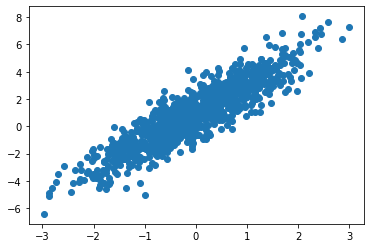

In [ ]:
plt.plot(features[:, 0], labels, 'o')

- 非线性相关规律

&emsp;&emsp;例如，此处创建一个满足$y=x^3+1$基本规律，并且白噪声很小的数据集进行建模测试

In [ ]:
# 设置随机数种子
np.random.seed(24)   

# 扰动项取值为0.01
features, labels = arrayGenReg(w=[2,1], deg=3, delta=0.01)

In [ ]:
features

array([[ 1.32921217,  1.        ],
       [-0.77003345,  1.        ],
       [-0.31628036,  1.        ],
       ...,
       [ 0.84682091,  1.        ],
       [ 1.73889649,  1.        ],
       [ 1.93991673,  1.        ]])

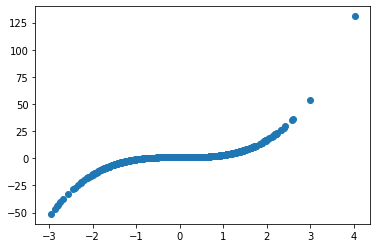

In [ ]:
plt.plot(features[:, 0], labels, 'o')

&emsp;&emsp;进行最小二乘法模型参数求解

In [ ]:
np.linalg.lstsq(features, labels, rcond=-1)

(array([[5.91925985],
        [0.96963333]]),
 array([28466.58711077]),
 2,
 array([32.13187164, 31.53261742]))

In [ ]:
w = np.linalg.lstsq(features, labels, rcond=-1)[0]
w

array([[5.91925985],
       [0.96963333]])

In [ ]:
SSELoss(features, w, labels)

array([[28466.58711077]])

In [ ]:
y_hat = features.dot(w)

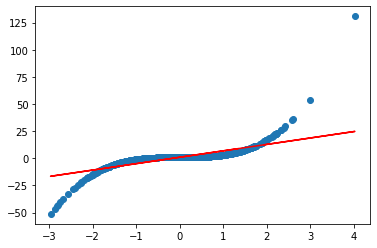

In [ ]:
plt.plot(features[:, 0], labels, 'o')
plt.plot(features[:, 0], y_hat, 'r-')

&emsp;&emsp;从模型结果能够看出，模型和数据集分布规律相差较大

- 噪声增加

&emsp;&emsp;此外，我们稍微增加模型白噪声，测试线性回归模型效果

In [ ]:
# 设置随机数种子
np.random.seed(24)   

# 扰动项取值为2
features, labels = arrayGenReg(w=[2,1], delta=2)

In [ ]:
features

array([[ 1.32921217,  1.        ],
       [-0.77003345,  1.        ],
       [-0.31628036,  1.        ],
       ...,
       [ 0.84682091,  1.        ],
       [ 1.73889649,  1.        ],
       [ 1.93991673,  1.        ]])

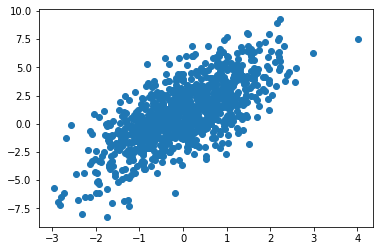

In [ ]:
plt.plot(features[:, 0], labels, 'o')

In [ ]:
np.linalg.lstsq(features, labels, rcond=-1)

(array([[1.91605821],
        [0.90602215]]),
 array([3767.12804359]),
 2,
 array([32.13187164, 31.53261742]))

In [ ]:
w = np.linalg.lstsq(features, labels, rcond=-1)[0]
w

array([[1.91605821],
       [0.90602215]])

In [ ]:
SSELoss(features, w, labels)

array([[3767.12804359]])

In [ ]:
X = np.linspace(-5, 5, 1000)
y = w[0] * X + w[1]

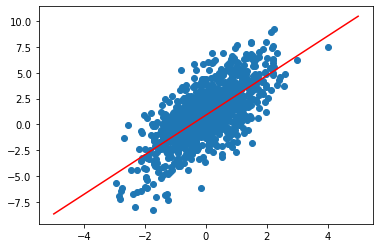

In [ ]:
plt.plot(features[:, 0], labels, 'o')
plt.plot(X, y, 'r-')

能够发现，模型误差较大。

- 最小二乘法条件限制

&emsp;&emsp;并且，除此之外，线性回归模型还面临这一个重大问题就是，如果特征矩阵的交叉乘积不可逆，则最小二乘法求解过程就不成立了。

$$\hat w = (X^TX)^{-1}X^Ty$$

当然，此时也代表着数据集存在着较为严重的多重共线性，换而言之就是数据集的特征矩阵可能可以相互线性表出。这个时候矩阵方程$X^TX\hat w=X^Ty$并不一定存在唯一解。解决该问题的方法有很多种，从数学角度出发，我们可以从以下三个方面入手：

- 其一，对数据进行降维处理：      
&emsp;&emsp;首先，可考虑进一步对数据集进行SVD分解或PCA主成分分析，在SVD或PCA执行的过程中会对数据集进行正交变换，最终所得数据集各列将不存在任何相关性。当然此举会对数据集的结构进行改变，且各列特征变得不可解释。

- 其二，修改求解损失函数的方法：      
&emsp;&emsp;我们可以试图求解原方程的广义逆矩阵，对于某些矩阵方程来说，通过求解广义逆矩阵，也可以得到近似最优解；此外，我们还可以通过使用其他最优化求解方法，如梯度下降算法等来进行求解；    

  - 其三，修改损失函数：      
&emsp;&emsp;其实可以修改原损失函数，令其满足最小二乘法求解条件即可。如果$X^TX$不可逆，那么我们可以通过试图在损失函数中加入一个正则化项，从而令损失函数可解。根据Lesson 2中的公式推导，目前根据SSE所构建的损失函数如下：

$$SSELoss(\hat w) = ||y - X\hat w||_2^2 = (y - X\hat w)^T(y - X\hat w)$$

通过数学过程可以证明，此时如果我们在原有损失函数基础上添加一个关于参数$w$的1-范数($||\hat w||_1$)或者2-范数($||\hat w||_2$)的某个计算结果，则可令最小二乘法条件得到满足。此时最小二乘法计算结果由无偏估计变为有偏估计。例如，当我们在损失函数中加上$\lambda ||\hat w||_2^2$（其中$\lambda$为参数）时，模型损失函数为：

$$Loss(\hat w) = ||y - X\hat w||_2^2 +\lambda ||\hat w||_2^2$$

经过数学转化，上述矩阵表达式对$\hat w$求导后令其为零，则可解出：

$$(X^TX+\lambda I) \hat w = X^Ty$$

其中$I$为单位矩阵。此时由于$(X^TX+\lambda I)$肯定是可逆矩阵，因此可以顺利求解出$\hat w$：

$$\hat w = (X^TX+\lambda I)^{-1}X^Ty$$

该过程也被称为岭回归。而类似的，如果是通过添加了$\hat w$的1-范数的某个表达式，从而构造损失函数如下：

$$Loss(\hat w) = ||y - X\hat w||_2^2 +\lambda ||\hat w||_1$$

则该过程被称为Lasso。而更进一步，如果构建的损失函数同时包含$\hat w$的1-范数和2-范数，形如如下形式：

$$Loss(\hat w) = \frac{1}{2n}||y - X\hat w||_2^2 + \lambda \alpha ||\hat w||_1 +\frac{\lambda(1-\alpha)}{2} ||\hat w||_2 ^ 2$$

则构建的是弹性网模型（Elastic-Net），其中$\lambda、\alpha$都是参数，n是样本个数。不难发现，岭回归和Lasso其实都是弹性网的一种特殊形式。更多关于线性模型的相关方法，我们将在后续逐渐介绍。

> 1-范数也被称为L1范数，将参数的1-范数添加入损失函数的做法，也被称为损失函数的L1正则化，L2正则化也类似。在大多数情况下，添加正则化项也可称为添加惩罚函数$p(w)$，核心作用是缓解模型过拟合倾向。

## 三、线性回归的决定系数

&emsp;&emsp;对于线性回归模型来说，除了SSE以外，我们还可使用决定系数（R-square，也被称为拟合优度检验）作为其模型评估指标。决定系数的计算需要使用之前介绍的组间误差平方和和离差平方和的概念。在回归分析中，SSR表示聚类中类似的组间平方和概念，表意为Sum of squares of the regression，由预测数据与标签均值之间差值的平方和计算的出：

$$SSR =\sum^{n}_{i=1}(\bar{y_i}-\hat{y_i})^2$$

而SST（Total sum of squares）则是实际值和均值之间的差值的平方和计算得到：

$$SST =\sum^{n}_{i=1}(\bar{y_i}-y_i)^2$$

并且，$SST$可由$SSR+SSE$计算得出。而决定系数，则由$SSR$和$SST$共同决定：

$$R-square=\frac{SSR}{SST}=\frac{SST-SSE}{SSE}=1-\frac{SSE}{SST}$$

很明显，决定系数是一个鉴于[0,1]之间的值，并且约趋近于1，模型拟合效果越好。我们可以通过如下过程，进行决定系数的计算：

In [ ]:
sst = np.power(labels - labels.mean(), 2).sum()
sse = SSELoss(features, w, labels)

In [ ]:
r = 1-(sse/sst)

In [ ]:
r

array([[0.50011461]])